## Full example the includes all python scripts within the repo.

In [ ]:
# IF RUNNING IN COLAB, RUN THIS CELL FIRST
# Clone the repository so we can access the data
!git clone https://github.com/lambjames18/PythonImageProcessing-MaterialsScience

In [8]:
# imports
import os
import numpy as np
from skimage import io, exposure, filters, img_as_float, morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import torch
from sklearn import preprocessing, decomposition
import matplotlib.pyplot as plt
# Activate the interactive mode of matplotlib within colab (if we are using colab)
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass
# Static plots
%matplotlib inline

# Set device to the GPU if available
# For MacOS, use the Multi-Process Service (MPS) to run on the GPU if available
if os.name == "nt":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
elif os.name == "posix":
    if os.uname().sysname == "Darwin":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    else:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

# Define a few helper functions
def norm(image):
    """Normalize the image to the range [0, 255] and convert to uint8."""
    image = image.astype(float)
    return np.around(255 * (image - image.min(axis=(0, 1))) / (image.max(axis=(0, 1)) - image.min(axis=(0, 1)))).astype(np.uint8)


def un_norm(image):
    """Rescale the image to the range [0, 1]."""
    image = image.astype(float)
    return ((image - image.min(axis=(0, 1))) / (image.max(axis=(0, 1)) - image.min(axis=(0, 1))))

Using cuda:0


#### Simple denoising

In [ ]:
# Read in the image
im = io.imread("./imgs/EBSD-Pattern.tif").astype(float)

# Create a dynamic background (really blurred version of the image) and subtract it from the original image
background = filters.gaussian(im, sigma=50)
im_new = un_norm(im - background)

# Apply contrast limiting adaptive histogram equalization (CLAHE) to the background-removed image
im_new_clahe = exposure.equalize_adapthist(im_new, clip_limit=0.01)

# Normalize the images and save them
im = norm(im)
background = norm(background)
im_new = norm(im_new)
im_new_clahe = norm(im_new_clahe)

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
ax[0, 0].imshow(im, cmap="gray")
ax[0, 0].set_title("Original")
ax[0, 1].imshow(background, cmap="gray")
ax[0, 1].set_title("Background")
ax[1, 0].imshow(im_new, cmap="gray")
ax[1, 0].set_title("Background Removed")
ax[1, 1].imshow(im_new_clahe, cmap="gray")
ax[1, 1].set_title("CLAHE")
for a in ax.ravel():
    a.axis("off")
plt.tight_layout()
plt.show()

#### Histogram manipulation

uint8 0 255


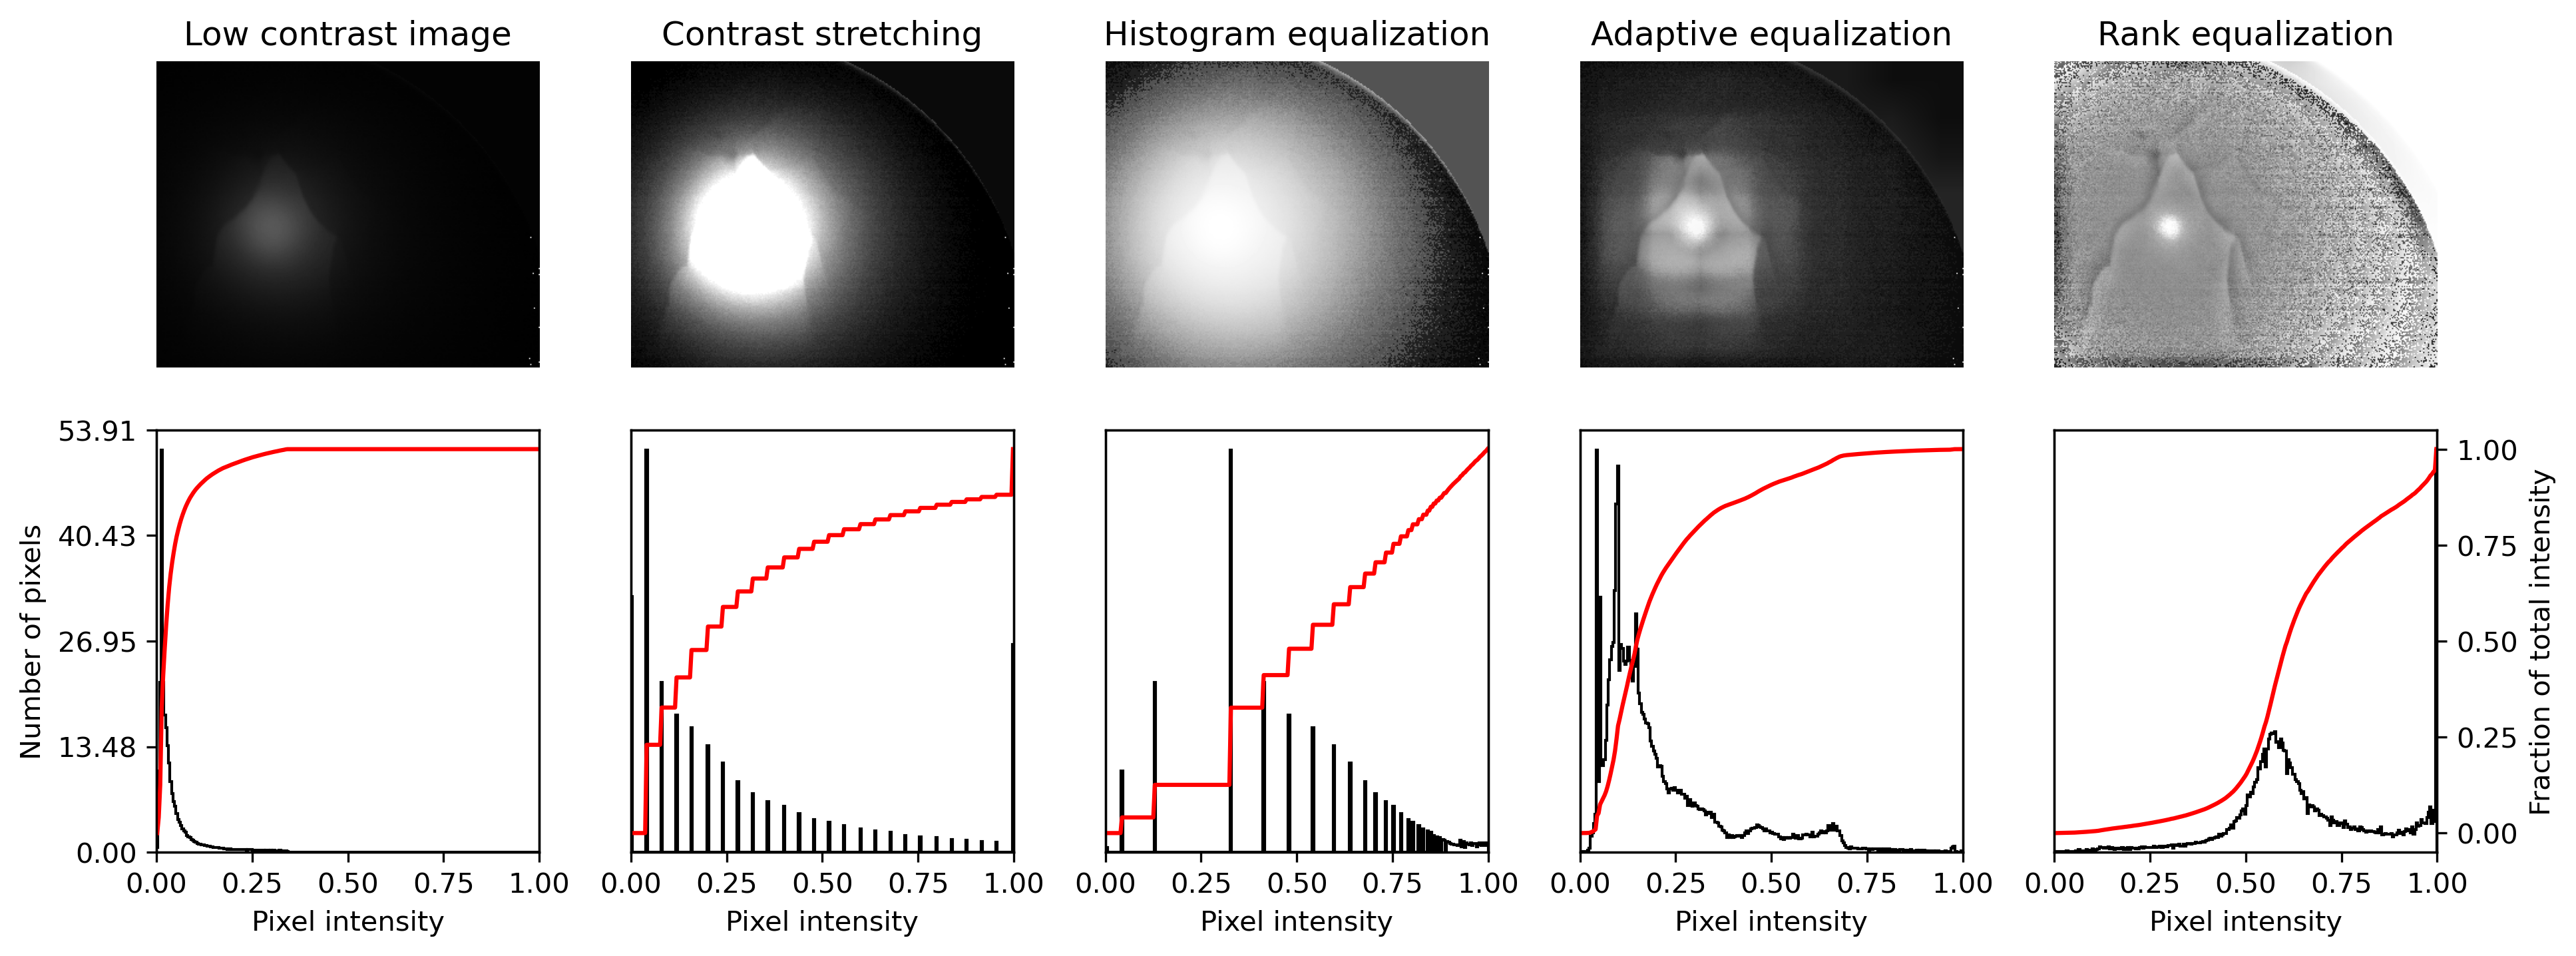

In [14]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black', density=True)
    # ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

img = io.imread("./imgs/CeO2.tiff", as_gray=True) - io.imread("./imgs/CeO2_Background.tiff", as_gray=True)
img = norm(img)

# Contrast stretching
p10, p90 = np.percentile(img, (10, 90))
img_rescale = exposure.rescale_intensity(img, in_range=(p10, p90))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.05)

# Rank equalization
rank = filters.rank.equalize(img, morphology.disk(20))

# Display results
fig = plt.figure(figsize=(13, 5), dpi=300)
axes = np.zeros((2, 5), dtype=object)
axes[0, 0] = fig.add_subplot(2, 5, 1)
for i in range(1, 5):
    axes[0, i] = fig.add_subplot(2, 5, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 5):
    axes[1, i] = fig.add_subplot(2, 5, 6+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(rank, axes[:, 4])
ax_img.set_title('Rank equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

#### Matrix convolution

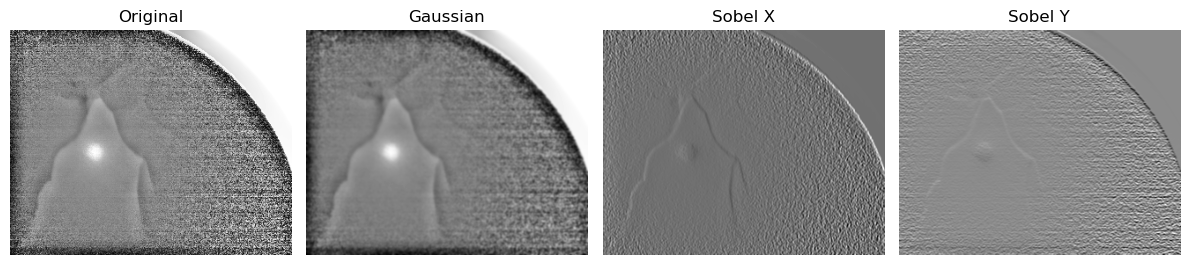

In [12]:
# Show what different kernels do to the image
im_grey = io.imread("./imgs/CeO2.tiff", as_gray=True) - io.imread("./imgs/CeO2_Background.tiff", as_gray=True)

# Lets apply a rank histogram equalization to the image first to improve the contrast
im_grey = filters.rank.equalize(im_grey, morphology.disk(20))

# Apply different filters to the image
sobelx = filters.sobel_v(im_grey)  # Vertical edges
sobely = filters.sobel_h(im_grey)  # Horizontal edges
gaussian = filters.gaussian(im_grey, sigma=1)

fig ,ax = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_grey, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(gaussian, cmap="gray")
ax[1].set_title("Gaussian")
ax[2].imshow(sobelx, cmap="gray")
ax[2].set_title("Sobel X")
ax[3].imshow(sobely, cmap="gray")
ax[3].set_title("Sobel Y")
for a in ax.ravel():
    a.axis("off")
plt.tight_layout()
plt.show()

#### Principal component analysis (PCA)

In [ ]:
# Read in the data file, select ROI (keeping all features), and extract dataset shape and number of features
data = np.load("./EBSD_data.npy")
"""
Structure of the data: (n_features, n_rows, n_columns)
Labels for the feature entries: Euler_1, Euler_2, Euler_3, GROD, IPF001_1, IPF001_2, IPF001_3, IPF100_1, IPF100_2, IPF100_3, MisIPF001_1, MisIPF001_2, MisIPF001_3, MisIPF100_1, MisIPF100_2, MisIPF100_3, KAM, CI, Phase, IQ
"""

# Put the features in the last dimension
data = np.moveaxis(data, 0, -1)

# Get the number of features and the shape of the dataset
n_features = data.shape[-1]
shape = data.shape

# Scale the data and perform PCA
data_scaled = preprocessing.StandardScaler().fit_transform(data.reshape(-1, n_features))
pca = decomposition.PCA(n_components=n_features)
X_pca = pca.fit_transform(data_scaled)
X_pca = X_pca.reshape(shape)

# Plot the results
fig, ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
ax[0, 0].imshow(X_pca[:, :, 0], cmap="gray")
ax[0, 1].imshow(X_pca[:, :, 1], cmap="gray")
ax[0, 2].imshow(X_pca[:, :, 2], cmap="gray")
ax[1, 0].imshow(data[:, :, 3], cmap="gray")  # GROD
ax[1, 1].imshow(data[:, :, -1], cmap="gray")  # CI
ax[1, 2].imshow(data[:, :, 4:7].astype(int))  # IPF
for a in ax.ravel():
    a.axis("off")
labels = ["PCA1", "PCA2", "PCA3", "GROD", "CI", "IPF"]
for i, a in enumerate(ax.ravel()):
    a.text(0.02, 0.98, labels[i], color="black", transform=a.transAxes, fontsize=14, verticalalignment="top", fontweight="heavy", backgroundcolor="white")
    
plt.tight_layout()
plt.show()

#### Variational autoencoder (VAE)

In [ ]:
### Variational autoencoder structure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class VEncoder(nn.Module):
    def __init__(self, height, width, n_features, latent_size):
        super(VEncoder, self).__init__()
        self.height = height
        self.width = width
        self.conv0 = nn.Conv2d(n_features, 16, kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * (self.height // 8) * (self.width // 8), latent_size)
        self.fc_logvar = nn.Linear(64 * (self.height // 8) * (self.width // 8), latent_size)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class VDecoder(nn.Module):
    def __init__(self, height, width, n_features, latent_size):
        super(VDecoder, self).__init__()
        self.height = height
        self.width = width
        self.fc = nn.Linear(latent_size, 64 * (self.height // 8) * (self.width // 8))
        self.deconv0 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, n_features, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 64, (self.height // 8), (self.width // 8))
        x = F.relu(self.deconv0(x))
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        return x


class VAutoencoder(nn.Module):
    def __init__(self, height, width, n_features, latent_size, lr=0.001):
        super(VAutoencoder, self).__init__()
        self.encoder = VEncoder(height, width, n_features, latent_size)
        self.decoder = VDecoder(height, width, n_features, latent_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(-1.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def get_latent_vectors(self, x, num_samples=0):
        with torch.no_grad():
            mu, logvar = self.encoder(x)
            latent_vectors = []
            for _ in range(num_samples):
                z = self.reparameterize(mu, logvar)
                latent_vectors.append(z)
        return torch.stack(latent_vectors).squeeze(0)

    def train(self, input_data, num_epochs):
        for epoch in range(num_epochs):
            # Forward pass
            output_data, mu, logvar = self(input_data)

            # Compute the loss, including the KL divergence term
            reconstruction_loss = self.criterion(output_data, input_data)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_divergence

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}' + " " * 10, end="\r", flush=True)
        print(f'Final Loss: {loss.item():.4f}, Final reconstruction Loss: {reconstruction_loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}' + " " * 20)

In [ ]:
### Example usage

# Define the latent space size for the VAE
latent_size = 20  # Can be tuned

# Read in the data file, select ROI (keeping all features), and extract dataset shape and number of features
data = np.load("./imgs/EBSD_data.npy")[:, :448, :512]

"""
Structure of the data: (n_features, n_rows, n_columns)
Features: Euler_1, Euler_2, Euler_3, GROD, IPF001_1, IPF001_2, IPF001_3, IPF100_1, IPF100_2, IPF100_3, MisIPF001_1, MisIPF001_2, MisIPF001_3, MisIPF100_1, MisIPF100_2, MisIPF100_3, KAM, CI, Phase, IQ
"""

# Put the features in the last dimension
data = np.moveaxis(data, 0, -1)

height, width, n_features = data.shape
batch_size = 1 # Because we are using a single image

# Preprocess data to be between 0 and 1 and have a mean of 0 and standard deviation of 1
input_data = (data - data.min(axis=(1, 2))[:, None, None]) / (data.max(axis=(1, 2)) - data.min(axis=(1, 2)))[:, None, None]
input_data = (input_data - input_data.mean(axis=(1, 2))[:, None, None]) / input_data.std(axis=(1, 2))[:, None, None]
input_data = torch.from_numpy(input_data).float().unsqueeze(0).to(device)
# For VAE, the input data should be in the shape (Batches, Channels, Height, Width)
input_data = torch.moveaxis(input_data, -1, 1)

# Example usage:
vae = VAutoencoder(input_data.shape[2], input_data.shape[3], n_features, latent_size).to(device)
vae.train(input_data, 100)

# Sample a few latent space vectors (analogous to PCA vectors)
vae_data = vae.get_latent_vectors(input_data, num_samples=3).cpu().numpy()
vae_data = np.squeeze(vae_data)

# Process the results into images
new_data = data.dot(vae_data.T)
grod = data[:, :, 3]
ci = data[:, :, -1]
ipf = data[:, :, 4:7].astype(int)

# Visualize
fig, ax = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
ax[0, 0].imshow(new_data[:, :, 0], cmap="gray")
ax[0, 1].imshow(new_data[:, :, 1], cmap="gray")
ax[0, 2].imshow(new_data[:, :, 2], cmap="gray")
ax[1, 0].imshow(grod, cmap="gray")
ax[1, 1].imshow(ci, cmap="gray")
ax[1, 2].imshow(ipf)
for a in ax.ravel():
    a.axis("off")
labels = ["VAE1", "VAE2", "VAE3", "GROD", "CI", "IPF"]
for i, a in enumerate(ax.ravel()):
    a.text(0.02, 0.98, labels[i], color="black", transform=a.transAxes, fontsize=14, verticalalignment="top", fontname="Avenir", fontweight="heavy", backgroundcolor="white")

plt.tight_layout()
plt.show()



#### Watershed segmentation + SNOW algorithm

In [ ]:
### SNOW algorithm
r'''
SNOW: Sub-Network of an Oversegmented Watershed
Copyright (C) 2017 Jeff Gostick

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
'''

import numpy as np
import scipy as sp
import scipy.ndimage as spim
import scipy.spatial as sptl
import matplotlib.pyplot as plt
from skimage import feature, segmentation


def trim_nearby_peaks(peaks, dt):
    """Function to remove peaks that are too close to each other in the distance map"""
    if dt.ndim == 2:
        from skimage.morphology import square as cube
    else:
        from skimage.morphology import cube
    peaks, N = spim.label(peaks, structure=cube(3))
    crds = spim.center_of_mass(peaks, labels=peaks, index=np.arange(1, N+1))
    crds = np.vstack(crds).astype(int)  # Convert to numpy array of ints
    # Get distance between each peak as a distance map
    tree = sptl.cKDTree(data=crds)
    temp = tree.query(x=crds, k=2)
    nearest_neighbor = temp[1][:, 1]
    dist_to_neighbor = temp[0][:, 1]
    del temp, tree  # Free-up memory
    dist_to_solid = dt[list(crds.T)]  # Get distance to solid for each peak
    dist_to_solid = dt[tuple(crds.T)]
    hits = np.where(dist_to_neighbor < dist_to_solid)[0]
    # Drop peak that is closer to the solid than its neighbor
    drop_peaks = []
    for peak in hits:
        if dist_to_solid[peak] < dist_to_solid[nearest_neighbor[peak]]:
            drop_peaks.append(peak)
        else:
            drop_peaks.append(nearest_neighbor[peak])
    drop_peaks = np.unique(drop_peaks)
    # Remove peaks from image
    slices = spim.find_objects(input=peaks)
    for s in drop_peaks:
        peaks[slices[s]] = 0
    return (peaks > 0)


def extend_slice(s, shape, pad=1):
    """Function to pad a slice by a given amount"""
    a = []
    for i, dim in zip(s, shape):
        start = 0
        stop = dim
        if i.start - pad >= 0:
            start = i.start - pad
        if i.stop + pad < dim:
            stop = i.stop + pad
        a.append(slice(start, stop, None))
    return tuple(a)


def trim_saddle_points(peaks, dt, max_iters=10):
    """Function to remove saddle points from the peaks"""
    if dt.ndim == 2:
        from skimage.morphology import square as cube
    else:
        from skimage.morphology import cube
    labels, N = spim.label(peaks)
    slices = spim.find_objects(labels)
    for i in range(N):
        s = extend_slice(s=slices[i], shape=peaks.shape, pad=10)
        peaks_i = labels[s] == i + 1
        dt_i = dt[s]
        im_i = dt_i > 0
        iters = 0
        peaks_dil = peaks_i.copy()

        while iters < max_iters:
            iters += 1
            peaks_dil = spim.binary_dilation(input=peaks_dil,
                                             structure=cube(3))
            peaks_max = peaks_dil*np.amax(dt_i*peaks_dil)
            peaks_extended = (peaks_max == dt_i)*im_i
            if np.all(peaks_extended == peaks_i):
                break  # Found a true peak
            elif np.sum(peaks_extended*peaks_i) == 0:
                peaks_i = False
                break  # Found a saddle point
            peaks[s] = peaks_i
    return peaks


def snow(im, sigma, r_max):
    """Function to perform the SNOW algorithm on an image"""
    dt = spim.distance_transform_edt(input=im)
    dt = spim.gaussian_filter(input=dt, sigma=sigma)
    peaks_locs = feature.peak_local_max(image=dt, min_distance=r_max-1, exclude_border=0) #, indices=False)
    peaks = np.zeros(shape=dt.shape, dtype=bool)
    peaks[tuple(peaks_locs.T)] = True
    peaks = trim_saddle_points(peaks=peaks, dt=dt)
    peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
    regions = segmentation.watershed(image=-dt, markers=spim.label(peaks)[0], mask=im)
    return regions


def create_image(shape, porosity, radius=10):
    """Function to create a synthetic image with a given porosity"""
    im = np.ones(shape=shape, dtype=bool)
    while im.sum()/im.size > porosity:
        temp = np.random.rand(*shape) < 0.9999
        temp = spim.distance_transform_edt(input=temp) > radius
        im *= temp
    return np.logical_not(im)



In [ ]:
### Example usage

# Get the image
im = io.imread("./imgs/WCu-Composite.tiff")

# Create a mask of the tungsten particles
tungsten_mask = im > filters.threshold_otsu(im)

# Set the minimum distance between seed points
min_distance = 50

# Calculate the distance to the nearest zero pixel for each pixel of the image
distance = ndi.distance_transform_edt(tungsten_mask)
# Find the peaks in the distance map
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=tungsten_mask, min_distance=20)
# Create the markers for the watershed algorithm
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
# Label the seed points as markers for the watershed algorithm
markers, _ = ndi.label(mask)
# Perform the watershed algorithm
labels = watershed(-distance, markers, mask=tungsten_mask)

### Now we will use the SNOW algorithm to segment the image
sigma = 0.1
r_max = 5
labels_snow = snow(im=tungsten_mask, sigma=sigma, r_max=r_max)

# Randomize the labels to make the plot look better, do this for both the original and SNOW labels
def shuffle_labels(labels, seed=0):
    unique_ids = np.unique(labels)[1:]  # Remove 0 because its the background
    np.random.seed(seed)
    np.random.shuffle(unique_ids)
    unique_ids = np.concatenate(([0], unique_ids))  # Add 0 back to the beginning
    shuffled_labels = np.zeros_like(labels)
    for i, unique_id in enumerate(unique_ids):
        shuffled_labels[labels == unique_id] = i
    return shuffled_labels

shuffled_labels = shuffle_labels(labels)
shuffled_labels_snow = shuffle_labels(labels_snow)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[0].axis('off')
ax[1].imshow(shuffled_labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Separated objects')
ax[1].axis('off')
ax[2].imshow(shuffled_labels_snow, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects (SNOW)')
ax[2].axis('off')
plt.tight_layout()
plt.show()

#### Data augmentation

In [ ]:
# Read in the image
image = io.imread("./imgs/CeO2.tiff", as_gray=True)
background = io.imread("./imgs/CeO2_Background.tiff", as_gray=True)

image = image - background  # Remove the background
image = image[:, :image.shape[0]]  # Crop the image to make it square
image = (image - image.min()) / (image.max() - image.min())  # Normalize the image within the range [0, 1]

# Rotate image
rot_image = np.rot90(image, 1)

# Intensity adjustment
adj_image = exposure.adjust_gamma(image, 0.5)

# Sharpen image
sharpened_image = filters.unsharp_mask(image, radius=1, amount=10)

# Create synthetic data
input_data = (image - image.mean()) / image.std()
input_data = torch.from_numpy(input_data).float().unsqueeze(0).unsqueeze(0).to(device)
vae = VAE.VAutoencoder(input_data.shape[2], input_data.shape[3], 1, 10).to(device)
vae.train(input_data, 1000)
vae_image = vae(input_data)[0].detach().squeeze().cpu().numpy()

# Export the images
image = np.around(255 * (image - image.min()) / (image.max() - image.min())).astype(np.uint8)
rot_image = np.around(255 * (rot_image - rot_image.min()) / (rot_image.max() - rot_image.min())).astype(np.uint8)
adj_image = np.around(255 * (adj_image - adj_image.min()) / (adj_image.max() - adj_image.min())).astype(np.uint8)
sharpened_image = np.around(255 * (sharpened_image - sharpened_image.min()) / (sharpened_image.max() - sharpened_image.min())).astype(np.uint8)
vae_image = np.around(255 * (vae_image - vae_image.min()) / (vae_image.max() - vae_image.min())).astype(np.uint8)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(image, cmap="gray")
ax[0, 0].set_title("Original")
ax[0, 1].imshow(rot_image, cmap="gray")
ax[0, 1].set_title("Rotated")
ax[0, 2].imshow(adj_image, cmap="gray")
ax[0, 2].set_title("Adjusted")
ax[1, 0].imshow(sharpened_image, cmap="gray")
ax[1, 0].set_title("Sharpened")
ax[1, 1].imshow(vae_image, cmap="gray")
ax[1, 1].set_title("VAE")
for a in ax.ravel():
    a.axis("off")
plt.tight_layout()
plt.show()